In [1]:
import os
import matplotlib.pyplot as plt
import pickle
import numpy as np
from keras import backend as K
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from skimage import img_as_ubyte
from keras.models import *
from keras.layers import *
from keras.optimizers import *
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout
from tensorflow.keras.initializers import he_normal
from sklearn.model_selection import train_test_split
import torch
from PIL import Image

In [2]:
# Checking if CUDA is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# def load_data(image_folder, mask_folder):
#     images = []
#     masks = []
#     for filename in os.listdir(image_folder):
#         img = np.array(Image.open(os.path.join(image_folder, filename)))
#         mask = np.array(Image.open(os.path.join(mask_folder, filename)))
#         images.append(img)
#         masks.append(mask)
#     return images, masks

# image_folder = "/content/drive/MyDrive/Augmented_data_LV/images"
# mask_folder = "/content/drive/MyDrive/Augmented_data_LV/masks"
# images, masks = load_data(image_folder, mask_folder)

In [ ]:
def load_data(image_folder, mask_folder):
    images = []
    masks = []
    for filename in os.listdir(image_folder):
        img = np.array(Image.open(os.path.join(image_folder, filename)))
        mask = np.array(Image.open(os.path.join(mask_folder, filename)))
        images.append(img)
        masks.append(mask)
    return images, masks

def save_dataset(images, masks, save_path):
    np.savez(save_path, images=images, masks=masks)
    print("Dataset saved successfully!")



# Paths
image_folder = "/content/drive/MyDrive/Augmented_data_LV/images"
mask_folder = "/content/drive/MyDrive/Augmented_data_LV/masks"
save_path = "/content/drive/MyDrive/Augmented_data_LV/dataset.npz"

# Load data
images, masks = load_data(image_folder, mask_folder)

# Save dataset
save_dataset(images, masks, save_path)



In [4]:
save_path = "/content/drive/MyDrive/Augmented_data_LV_2/dataset.npz"

def load_dataset(dataset_path):
    data = np.load(dataset_path)
    images = data['images']
    masks = data['masks']
    return images, masks

# Load dataset
loaded_images, loaded_masks = load_dataset(save_path)

In [ ]:
image_folder = "/content/drive/MyDrive/Augmented_data_LV_2/images"
mask_folder = "/content/drive/MyDrive/Augmented_data_LV_2/masks"

count = 0

for file_name in os.listdir(image_folder):
  count+=1
print(count)

3338


In [5]:
print(len(loaded_images))
print(len(loaded_masks))

3500
3500


In [6]:
print(loaded_images)

[[[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ...  8  8  9]
  [ 0  0  0 ...  8  9 10]
  [ 0  0  0 ...  9 10 10]
  ...
  [ 8 12 16 ...  0  0  0]
  [12 16 21 ...  0  0  0]
  [16 21 26 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 ...

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]

 [[ 0  0  0 ... 44 41 37]
  [ 0  0  0 ... 39 35 30]
  [ 0  0  0 ... 32 27 22]
  ...
  [35 34 35 ...  0  0  0]
  [35 36 38 ...  0  0  0]
  [37 40 42 ...  0  0  0]]

 [[ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  ...
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]
  [ 0  0  0 ...  0  0  0]]]


In [7]:
def preprocess(images, masks, target_size=(256, 256)):
    images_resized = np.array([np.array(Image.fromarray(img).resize(target_size)) for img in images])
    masks_resized = np.array([np.array(Image.fromarray(mask).resize(target_size)) for mask in masks])

    # Add channel dimension
    images_resized = np.expand_dims(images_resized, axis=-1)
    masks_resized = np.expand_dims(masks_resized, axis=-1)

    # Normalize images to [0, 1]
    images_resized = images_resized / 255.0

    # Convert masks to binary
    masks_resized = np.where(masks_resized >= 128, 1.0, 0.0)

    return images_resized, masks_resized


In [8]:
images_preprocess,masks_preprocess = preprocess(loaded_images,loaded_masks)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(images_preprocess, masks_preprocess, test_size=0.2, random_state=42)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [11]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))
print(len(X_val))
print(len(y_val))

2240
2240
700
700
560
560


In [12]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (2240, 256, 256, 1)
y_train shape: (2240, 256, 256, 1)
X_test shape: (700, 256, 256, 1)
y_test shape: (700, 256, 256, 1)
X_val shape: (560, 256, 256, 1)
y_val shape: (560, 256, 256, 1)


In [13]:
X_train = X_train.reshape((2240, 256, 256, 1))
y_train = y_train.reshape((2240, 256, 256, 1))
X_val = X_val.reshape((560, 256, 256, 1))
y_val = y_val.reshape((560, 256, 256, 1))
X_test = X_test.reshape((700, 256, 256, 1))
y_test = y_test.reshape((700, 256, 256, 1))

In [14]:
# Define data generators without augmentation
train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

In [15]:
batch_size = 1
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=False)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)

In [16]:
seed = 1234
np.random.seed(seed)

startDir = '/content/drive/MyDrive/weights_folder/'
weights_dir = startDir

In [17]:
def show_images(images, dpi = 72, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    plt.rcParams['figure.dpi'] = dpi
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()
    plt.rcParams['figure.dpi'] = 72

In [18]:
def plot_rows_cols(imgs,ttls=[]):
  ofs = plt.rcParams['figure.figsize']
  fig=plt.figure(figsize=(16, 16))
  columns = 5
  rows = int(len(imgs)/columns)
  ax = []
  for i in range(1, columns*rows +1):
      img = imgs[i-1]
      ax.append(fig.add_subplot(rows, columns, i))
      if ttls != [] and len(imgs) == len(ttls):
        ax[-1].set_title(ttls[i-1])
      plt.imshow(img)
  plt.subplots_adjust(bottom=0.3,hspace=0)
  plt.show()
  plt.rcParams['figure.figsize'] = ofs

In [19]:
def addmask_border(img, msk, clr = (255,255,0), thickness = 1):
    image = img.copy()
    if np.ndim(image) == 2:
      #image = image.astype('uint8')
      image = img_as_ubyte(image)
      image = cv2.cvtColor(image,cv2.COLOR_GRAY2BGR)
    bmsk = msk.copy().astype('uint8')
    contours, _ = cv2.findContours(bmsk, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
      lenctrs = [len(ctr) for ctr in contours]
      maxctridx = np.argmax(lenctrs)
      pts = np.array([pt[0] for pt in contours[maxctridx]])
      cv2.polylines(image,[pts],True,clr, thickness = thickness)
    return(image)

In [20]:
# draw images with ndim 3 with shape (x,x,1)
def draw_images(imgs, titles = None, dpi = 72):
  simgs = []
  for i in range(len(imgs)):
    simg = np.squeeze(imgs[i])
    simgs.append(simg)
  show_images(simgs, titles=titles, dpi = dpi)

In [21]:
def draw_overlap_border(image, mask, dpi = 72, thickness = 1, clr = (0,255,0), title = ['border in green'] ):
  img1 = np.squeeze(image)
  img2 = np.squeeze(mask)
  bimg1 = addmask_border(img1, img2, clr = clr, thickness = thickness)
  show_images([bimg1],titles=title, dpi = dpi)

In [22]:
def find_overlap_border(image, mask, thickness = 1, clr = (255,0,0)):
  img1 = np.squeeze(image)
  img2 = np.squeeze(mask)
  bimg1 = addmask_border(img1, img2, clr = clr, thickness = thickness)
  return(bimg1)

In [23]:
def find_border(chkidx, imgarr, mskarr, clr=(255,255,0), thickness = 1):
  img1 = imgarr[chkidx]
  img1 = np.squeeze(img1)
  img2 = mskarr[chkidx]
  img2 = np.squeeze(img2)
  img2 = np.array(img2, dtype=np.uint8)
  img3 = addmask_border(img1,img2,clr=clr,thickness = thickness)
  #img3 = cv2.cvtColor(img3,cv2.COLOR_BGR2GRAY)
  return(img3)

In [24]:
def get_imagestodraw(idx, imgarr, mskarr, predarr):
    idx = idx
    img_border = find_border(idx, imgarr, mskarr, thickness = 2, clr = (255,255,0))
    img_border = find_overlap_border(img_border, predarr[idx], thickness = 2, clr = (255,0,0))
    #print(img_border.shape)

    msk_t = mskarr[idx]
    msk_t = np.squeeze(msk_t)
    msk_t = np.array(msk_t, dtype=np.uint8)
    msk_t[msk_t==1] = 255
    msk_t = cv2.cvtColor(msk_t,cv2.COLOR_GRAY2BGR)
    msk_t[np.where((msk_t==[255,255,255]).all(axis=2))] = [255,255,0]

    msk_p = predarr[idx]
    msk_p = np.squeeze(msk_p)
    msk_p = np.where(msk_p > 0.6,255.0,0.0)
    msk_p = np.array(msk_p,dtype=np.uint8)
    msk_p = cv2.cvtColor(msk_p,cv2.COLOR_GRAY2BGR)
    msk_p[np.where((msk_p==[255,255,255]).all(axis=2))] = [255,0,0]

    img_t = imgarr[idx]
    img_t = np.squeeze(img_t)
    img_t = img_as_ubyte(img_t)
    img_t = cv2.cvtColor(img_t,cv2.COLOR_GRAY2BGR)
    img_tm = img_t.copy()
    img_tm[(msk_t==[255,255,0]).all(axis=2)] = [255,255,0]
    img_tp = img_t.copy()
    img_tp[(msk_p==[255,0,0]).all(axis=2)] = [255,0,0]

    overlay = img_tm
    alpha = 0.5
    output = img_border   # img_t
    output_img = cv2.addWeighted(overlay, alpha, output, 1 - alpha, 0)
    alpha = 0.5
    overlay = img_tp   # msk_p
    output_img = cv2.addWeighted(overlay, alpha, output_img, 1 - alpha, 0)
    return (img_t, img_tm, img_tp, img_border, output_img)

In [25]:
def plot_training(results, loss1 = 'loss', mon1 = 'val_loss', mon2 = ''):
  plt.figure(figsize=(8, 8))
  plt.title("Learning curve")
  plt.plot(results.history[loss1], label=loss1)
  if mon1 in results.history.keys():
    plt.plot(results.history[mon1], label=mon1)
  if mon2 != '':
    if mon2 in results.history.keys():
      plt.plot(results.history[mon2], label=mon2)
  plt.xlabel("Epochs")
  plt.ylabel("loss/mon")
  plt.legend();

In [26]:
def store_output_images(imgcnt = 1, dictofimgs={'orig':None,'amsk':None,'pmsk':None,'bimg':None,'oimg':None}):
  thiscnt = 1
  for k in dictofimgs.keys():
    if dictofimgs[k] is None:
      pass
    else:
      fn = startDir + k + '_' + str(imgcnt) + '.png'
      img = dictofimgs[k]
      img  = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
      cv2.imwrite(fn,img)
      thiscnt += 1


In [27]:
# Model loss and monitor functions

def dice_coef(y_true, y_pred, smooth=0.0):
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    summation = K.sum(y_true, axis=axes) + K.sum(y_pred, axis=axes)

    return K.mean((2.0 * intersection + smooth) / (summation + smooth), axis=0)

def jaccard_coef(y_true, y_pred, smooth=0.0):
    axes = (1,2,3)
    intersection = K.sum(y_true * y_pred, axis=axes)
    union = K.sum(y_true, axis=axes) + K.sum(y_pred, axis=axes) - intersection
    return K.mean( (intersection + smooth) / (union + smooth), axis=0)

def dice_loss(smooth):
  def dice(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred, smooth=smooth)
  return dice

def dice_mon(smooth):
  def dicemon(y_true, y_pred):
    return dice_coef(y_true, y_pred, smooth=smooth)
  return dicemon

def jaccard_mon(smooth):
  def jaccardmon(y_true, y_pred):
    return jaccard_coef(y_true, y_pred, smooth=smooth)
  return jaccardmon

In [28]:
# THIS IS OUR MODEL ARCHITECTURE ie) U-NET WITH ATTENTION GATE

# Defining Convolutional Block
def conv_block(layer_before, features, block_no=0, activation='relu', padding='same', kernel_initializer='glorot_uniform', pool_bool=True):
    if pool_bool:
        block = '_convblock_' + str(block_no)
    else:
        block = '_middleblock'
    conv = Conv2D(features, 3, activation=activation, padding=padding, kernel_initializer=kernel_initializer, name='conv1' + block)(layer_before)
    conv = BatchNormalization()(conv)
    conv = Conv2D(features, 3, activation=activation, padding=padding, kernel_initializer=kernel_initializer, name='conv2' + block)(conv)
    conv = BatchNormalization()(conv)
    if pool_bool:
        conv = MaxPooling2D(pool_size=(2, 2), name='pool' + block)(conv)
    return conv

In [29]:
# Defining Deconvolution Block
def deconv_block(layer_before, features, block_no=0, activation='relu', padding='same', kernel_initializer='glorot_uniform'):
    if block_no == 0:
        conv = Conv2D(2, 3, activation=activation, padding=padding, kernel_initializer=kernel_initializer)(layer_before)
        return conv
    block = '_deconvblock_' + str(block_no)
    up = UpSampling2D(size=(2, 2), name='up' + block)(layer_before)
    conv = Conv2D(features, 2, activation=activation, padding=padding, kernel_initializer=kernel_initializer, name='conv1' + block)(up)
    conv = BatchNormalization()(conv)
    conv = Conv2D(features, 3, activation=activation, padding=padding, kernel_initializer=kernel_initializer, name='conv2' + block)(conv)
    conv = BatchNormalization()(conv)
    return conv

In [30]:
# Defining the Attention Mechanism
def SpatialAttention(input_feature, ratio=8):
    avg_pool = GlobalAveragePooling2D()(input_feature)
    avg_pool = Reshape((1, 1, avg_pool.shape[-1]))(avg_pool)
    avg_pool = Dense(input_feature.shape[-1] // ratio, activation='relu')(avg_pool)
    avg_pool = Dense(input_feature.shape[-1], activation='sigmoid')(avg_pool)
    multiplied = Multiply()([input_feature, avg_pool])
    added = Add()([input_feature, multiplied])
    return added

In [31]:
def encoder(input_layer, starting_features=64, depth=4):
    conv = input_layer
    features = starting_features
    for i in range(depth):
        conv = conv_block(conv, features, block_no=i+1)
        features *= 2
        conv = SpatialAttention(conv)
    return conv, features

def middle_layer(input_conv, features):
  return conv_block(input_conv, features, pool_bool=False)

def decoder(input_conv, features=1024, height=4):
    conv = input_conv
    features = int(features / 2)
    for i in range(height):
        conv = SpatialAttention(conv)
        conv = deconv_block(conv, features, block_no=i+1)
        features = int(features / 2)
    conv = deconv_block(conv, features, block_no=0)
    return conv

In [32]:
# Building the Attention U-Net model

def build_attention_unet(input_size=(256, 256, 1), depth=4):
    inputs = Input(input_size)
    conv, features = encoder(inputs, depth=depth)
    middle_conv = conv_block(conv, features, pool_bool=False)
    conv = decoder(middle_conv, features=features, height=depth)
    out = Conv2D(1, 1, activation='sigmoid')(conv)
    model = Model(inputs=inputs, outputs=out)
    return model

In [33]:
# Compile the Attention U-Net model

def compile_attention_model(depth=4):
    model = build_attention_unet(depth=depth)
    smooth = K.epsilon()
    model_dice = dice_loss(smooth=smooth)    #smooth=K.epsilon()
    dicemon = dice_mon(smooth)
    jaccardmon = jaccard_mon(smooth)
    sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
    model.compile(optimizer = sgd, loss = model_dice, metrics = [dicemon, jaccardmon])
    return model


In [34]:
# Instantiating the compiled Attention U-Net model
attention_model = compile_attention_model(depth=5)

In [35]:


model_name = 'attention_Model_augmented_data_18_05'
weights_dir = '/content/drive/MyDrive/weights_folder/'
weights_file = weights_dir + 'sunnybrook_' + model_name + '-{epoch:02d}.hdf5'
model_checkpoint = ModelCheckpoint(weights_file, monitor='val_dicemon', verbose=1, save_weights_only=True, period=5)


In [ ]:
# epochs = 20
# hist = attention_model.fit(train_generator,steps_per_epoch=2240,epochs=epochs,callbacks=[model_checkpoint], validation_data=val_generator, validation_steps=560)

In [ ]:
epochs = 10
hist = attention_model.fit(train_generator,steps_per_epoch=2240,epochs=epochs,callbacks=[model_checkpoint], validation_data=val_generator, validation_steps=560)

Epoch 1/10
2240/2240 [==============================] - 456s 193ms/step - loss: 0.4629 - dicemon: 0.5371 - jaccardmon: 0.3955 - val_loss: 0.5049 - val_dicemon: 0.4951 - val_jaccardmon: 0.3631
Epoch 2/10
2240/2240 [==============================] - 421s 188ms/step - loss: 0.4268 - dicemon: 0.5732 - jaccardmon: 0.4282 - val_loss: 0.5020 - val_dicemon: 0.4980 - val_jaccardmon: 0.3678
Epoch 3/10
2240/2240 [==============================] - 424s 189ms/step - loss: 0.4209 - dicemon: 0.5791 - jaccardmon: 0.4343 - val_loss: 0.5238 - val_dicemon: 0.4762 - val_jaccardmon: 0.3495
Epoch 4/10
2240/2240 [==============================] - 425s 190ms/step - loss: 0.4194 - dicemon: 0.5806 - jaccardmon: 0.4358 - val_loss: 0.4867 - val_dicemon: 0.5133 - val_jaccardmon: 0.3780
Epoch 5/10
2240/2240 [==============================] - ETA: 0s - loss: 0.4139 - dicemon: 0.5861 - jaccardmon: 0.4418
Epoch 5: saving model to /content/drive/MyDrive/weights_folder/sunnybrook_attention_Model_augmented_data_07/05/202

In [ ]:


model_name = 'attention_Model_augmented_data_10_05'
weights_dir = '/content/drive/MyDrive/weights_folder/'
weights_file = weights_dir + 'sunnybrook_' + model_name + '-{epoch:02d}.hdf5'
model_checkpoint = ModelCheckpoint(weights_file, monitor='val_dicemon', verbose=1, save_weights_only=True, period=5)


In [55]:
#model = attention_model()
#model_name = '2024-75.hdf5'
weights_file = '/content/drive/MyDrive/weights_folder/sunnybrook_attention_Model_augmented_data_09_05/2024-15.hdf5'
attention_model.load_weights(weights_file)

In [ ]:
# # Instantiating the compiled Attention U-Net model
# attention_model = compile_attention_model(depth=5)

In [ ]:
epochs_to_train = 15

hist = attention_model.fit(train_generator, steps_per_epoch=2240, epochs=epochs_to_train, callbacks=[model_checkpoint], validation_data=val_generator, validation_steps=560)

Epoch 1/15
2240/2240 [==============================] - 453s 191ms/step - loss: 0.1524 - dicemon: 0.8476 - jaccardmon: 0.7595 - val_loss: 0.6600 - val_dicemon: 0.3400 - val_jaccardmon: 0.2454
Epoch 2/15
2240/2240 [==============================] - 439s 196ms/step - loss: 0.1520 - dicemon: 0.8480 - jaccardmon: 0.7595 - val_loss: 0.7413 - val_dicemon: 0.2587 - val_jaccardmon: 0.1858
Epoch 3/15
2240/2240 [==============================] - 427s 191ms/step - loss: 0.1505 - dicemon: 0.8495 - jaccardmon: 0.7625 - val_loss: 0.6113 - val_dicemon: 0.3887 - val_jaccardmon: 0.2846
Epoch 4/15
2240/2240 [==============================] - 426s 190ms/step - loss: 0.1507 - dicemon: 0.8493 - jaccardmon: 0.7617 - val_loss: 0.6059 - val_dicemon: 0.3941 - val_jaccardmon: 0.2877
Epoch 5/15
2240/2240 [==============================] - ETA: 0s - loss: 0.1486 - dicemon: 0.8514 - jaccardmon: 0.7649
Epoch 5: saving model to /content/drive/MyDrive/weights_folder/sunnybrook_attention_Model_augmented_data_10_05-05.

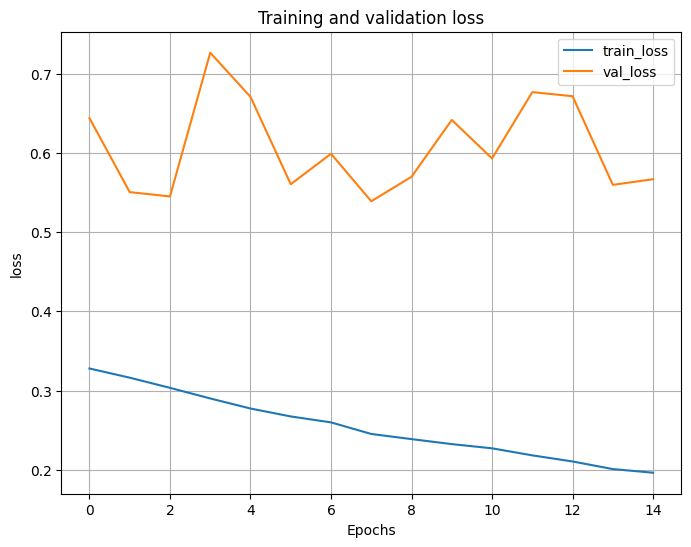

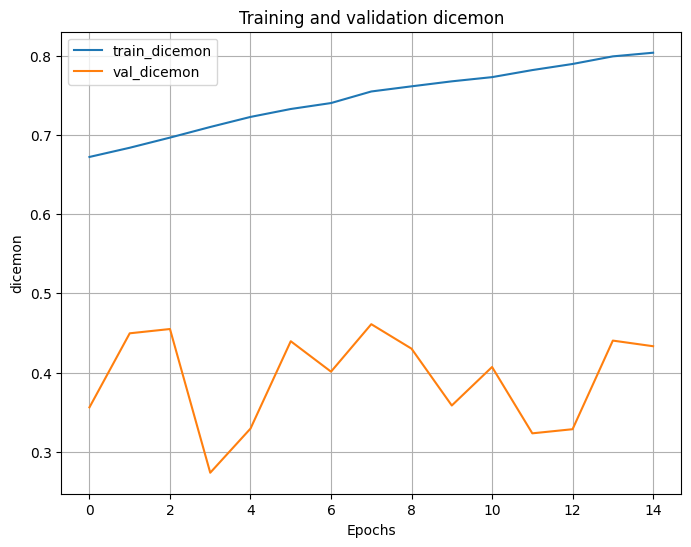

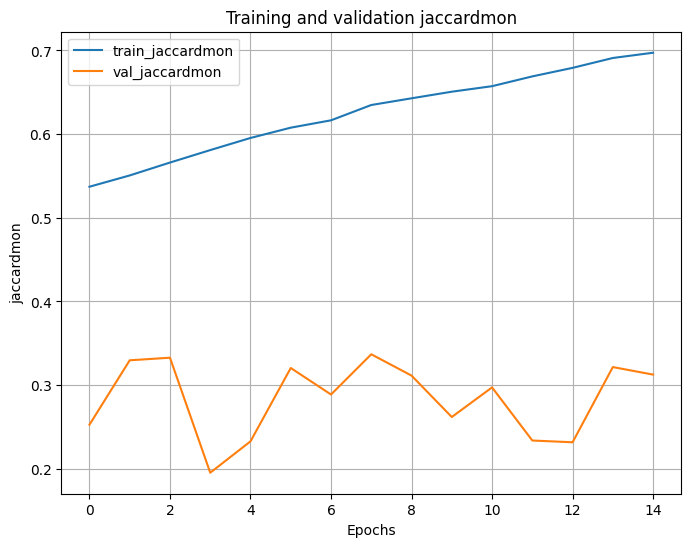

In [82]:
import matplotlib.pyplot as plt

# Parse the training history
history = {
    'loss': [0.3279, 0.3163, 0.3035, 0.2901, 0.2774, 0.2674, 0.2599, 0.2453, 0.2388, 0.2325, 0.2272, 0.2183, 0.2106, 0.2010, 0.1964],
    'val_loss': [0.6438, 0.5504, 0.5450, 0.7263, 0.6706, 0.5604, 0.5988, 0.5389, 0.5698, 0.6415, 0.5929, 0.6766, 0.6714, 0.5596, 0.5667],
    'dicemon': [0.6721, 0.6837, 0.6965, 0.7099, 0.7226, 0.7326, 0.7401, 0.7547, 0.7612, 0.7675, 0.7728, 0.7817, 0.7894, 0.7990, 0.8036],
    'val_dicemon': [0.3562, 0.4496, 0.4550, 0.2737, 0.3294, 0.4396, 0.4012, 0.4611, 0.4302, 0.3585, 0.4071, 0.3234, 0.3286, 0.4404, 0.4333],
    'jaccardmon': [0.5371, 0.5506, 0.5660, 0.5809, 0.5954, 0.6077, 0.6165, 0.6348, 0.6428, 0.6507, 0.6573, 0.6690, 0.6792, 0.6910, 0.6973],
    'val_jaccardmon': [0.2526, 0.3296, 0.3327, 0.1952, 0.2327, 0.3204, 0.2887, 0.3368, 0.3113, 0.2618, 0.2972, 0.2337, 0.2316, 0.3215, 0.3125]
}

# Define the plotting function
def plot_training(history, metrics=['loss', 'dicemon', 'jaccardmon']):
    for metric in metrics:
        plt.figure(figsize=(8, 6))
        plt.plot(history[metric], label=f'train_{metric}')
        plt.plot(history[f'val_{metric}'], label=f'val_{metric}')
        plt.title(f'Training and validation {metric}')
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()
        plt.grid(True)
        plt.show()

# Plot the training history
plot_training(history)


In [76]:
attention_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv1_convblock_1 (Conv2D)  (None, 256, 256, 64)         640       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv1_convblock_1[0][0]']   
 Normalization)                                                                                   
                                                                                                  
 conv2_convblock_1 (Conv2D)  (None, 256, 256, 64)         36928     ['batch_normalization[0][0

In [59]:
pred_masks = attention_model.predict(X_test, batch_size=1, verbose=1)

700/700 [==============================] - 31s 44ms/step


In [80]:
attention_model.keys()

AttributeError: 'Functional' object has no attribute 'keys'

TypeError: 'History' object is not subscriptable

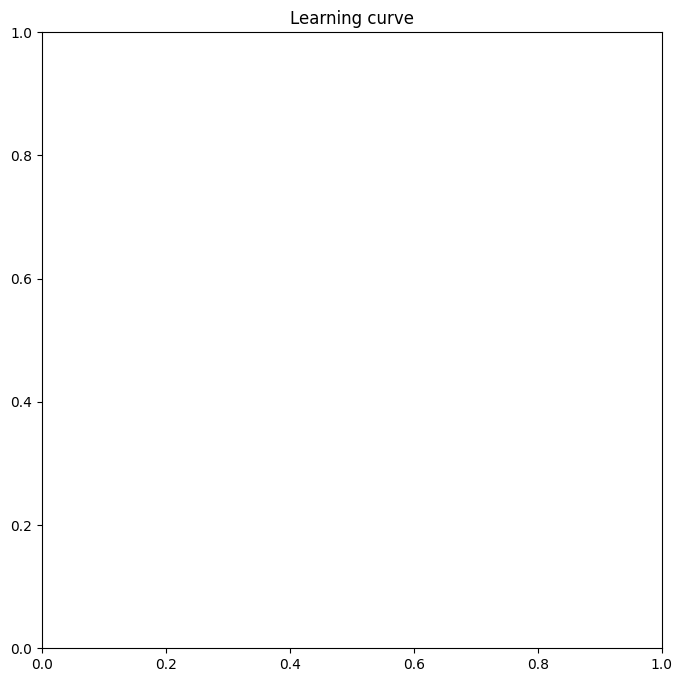

In [79]:
plot_training(attention_model, mon1='dice_coef')


In [ ]:
# allimgs = []
# for idx in range(40,60):
#   imgs = get_imagestodraw(idx, X_test, y_test, pred_masks)
#   allimgs.extend(list(imgs))

In [70]:
allimgs = []
for idx in range(98,104):
  imgs = get_imagestodraw(idx, X_test, y_test, pred_masks)
  allimgs.extend(list(imgs))

In [71]:
hdrs = ['orig','mask','pred','borders','overlaps']
ttls = []
nos = int(len(allimgs)/5)
for i in range(nos):
  ttls.extend(hdrs)

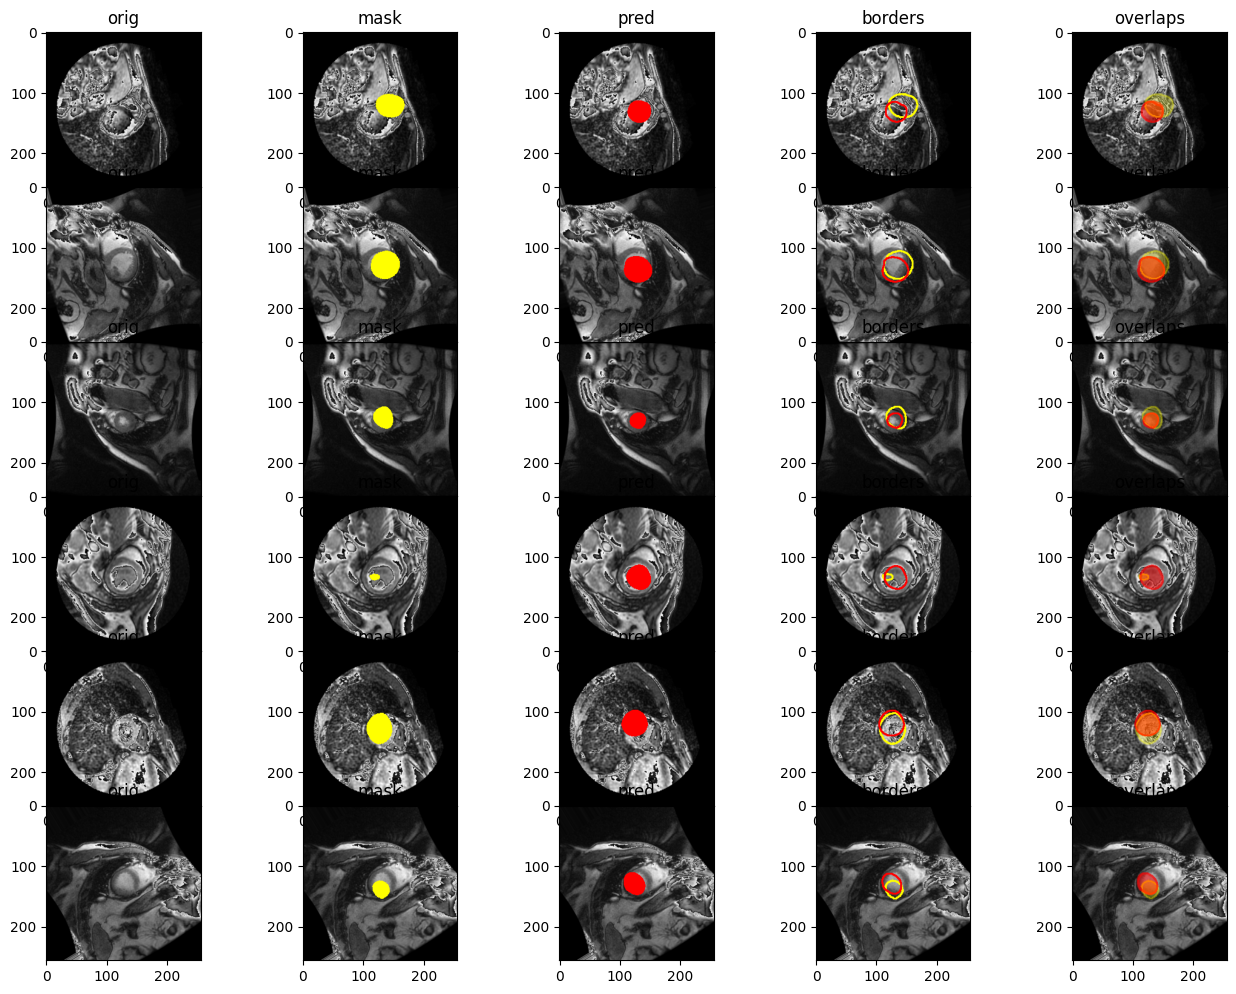

In [72]:
plot_rows_cols(allimgs,ttls)

## Testing Model


In [ ]:
# model = build_attention_unet(depth=5)
# #model_name = '2024-75.hdf5'
# weights_file = '/content/drive/MyDrive/2024-20.hdf5'
# model.load_weights(weights_file)

In [ ]:
# # Instantiating the compiled Attention U-Net model
# model = compile_attention_model(depth=5)

In [ ]:
# epochs = 10
# hist = model.fit(train_generator,steps_per_epoch=2240,epochs=epochs,callbacks=[model_checkpoint], validation_data=val_generator, validation_steps=560,initial_epoch=20)